# Digital Image Processing


In [48]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from tensorflow import keras
import cv2
import pickle
from tensorflow.keras import backend as K
from PIL import Image
import matplotlib.patches as mpatches

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [50]:
positive_dir = Path('C:/Users/dhanr/Desktop/Dip Image Segmentation/Positive')
negative_dir = Path('C:/Users/dhanr/Desktop/Dip Image Segmentation/Negative')

In [51]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [52]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,C:\Users\dhanr\Desktop\Dip Image Segmentation\...,POSITIVE
1,C:\Users\dhanr\Desktop\Dip Image Segmentation\...,POSITIVE
2,C:\Users\dhanr\Desktop\Dip Image Segmentation\...,POSITIVE
3,C:\Users\dhanr\Desktop\Dip Image Segmentation\...,NEGATIVE
4,C:\Users\dhanr\Desktop\Dip Image Segmentation\...,POSITIVE
...,...,...
39995,C:\Users\dhanr\Desktop\Dip Image Segmentation\...,POSITIVE
39996,C:\Users\dhanr\Desktop\Dip Image Segmentation\...,NEGATIVE
39997,C:\Users\dhanr\Desktop\Dip Image Segmentation\...,POSITIVE
39998,C:\Users\dhanr\Desktop\Dip Image Segmentation\...,POSITIVE


In [53]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

# Loading Image Data

In [54]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [55]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


# Training

In [56]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 32)               0   

In [57]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 [==============================] - 18s 153ms/step - loss: 0.6764 - accuracy: 0.5801 - val_loss: 0.6513 - val_accuracy: 0.7940
Epoch 2/100
105/105 [==============================] - 13s 128ms/step - loss: 0.6153 - accuracy: 0.7080 - val_loss: 0.5800 - val_accuracy: 0.6857
Epoch 3/100
105/105 [==============================] - 13s 125ms/step - loss: 0.5234 - accuracy: 0.7964 - val_loss: 0.5022 - val_accuracy: 0.8214
Epoch 4/100
105/105 [==============================] - 13s 125ms/step - loss: 0.4386 - accuracy: 0.8676 - val_loss: 0.3963 - val_accuracy: 0.9214
Epoch 5/100
105/105 [==============================] - 13s 125ms/step - loss: 0.3521 - accuracy: 0.9214 - val_loss: 0.3026 - val_accuracy: 0.9167
Epoch 6/100
105/105 [==============================] - 13s 125ms/step - loss: 0.2918 - accuracy: 0.9321 - val_loss: 0.2401 - val_accuracy: 0.9262
Epoch 7/100
105/105 [==============================] - 13s 126ms/step - loss: 0.2323 - accuracy: 0.9438 - val_loss: 0.2050 -

In [58]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [59]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.10440
Test Accuracy: 97.28%
57/57 [==============================] - 3s 55ms/step


C:\Users\dhanr\AppData\Local\Temp\ipykernel_17208\3772050799.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



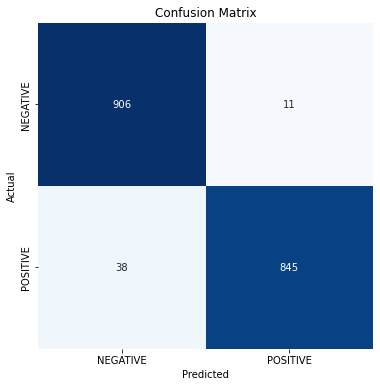

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.97       917
    POSITIVE       0.99      0.96      0.97       883

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



In [60]:
evaluate_model(model, test_data)

In [65]:
def test_new_data(dir_path):
    
    new_test_dir = Path(dir_path)
    
    df_new = generate_df(new_test_dir, 'Testing')
    
    test_data_new = test_gen.flow_from_dataframe(df_new, 
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120), 
                                          color_mode='rgb',
                                          batch_size=5,
                                          shuffle=False,
                                          seed=42)
    
        # predicted y values
    y_pred = np.squeeze((model.predict(test_data_new) >= 0.5).astype(np.int))
    
    
    y_certain = model.predict(test_data_new).round(6)
    y_out = []
    for i in y_pred:
        if i==0:
            y_out.append('Negative (Not Crack)')
        else:
            y_out.append('Positive(Crack) ')
            
    result = pd.DataFrame(np.c_[y_out, y_certain], columns=['Result', 'Confidance of being Cracked'])
    
    return result

In [66]:
results = test_new_data(r'C:\Users\dhanr\Desktop\Dip Image Segmentation\test')

Found 110 validated image filenames belonging to 1 classes.
 6/22 [=======>......................] - ETA: 0s

C:\Users\dhanr\AppData\Local\Temp\ipykernel_17208\1359312930.py:17: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



22/22 [==============================] - 0s 12ms/step


In [64]:
results = test_new_data(r'C:\Users\dhanr\Desktop\Dip Image Segmentation\test')

Found 110 validated image filenames belonging to 1 classes.
 6/22 [=======>......................] - ETA: 0s

C:\Users\dhanr\AppData\Local\Temp\ipykernel_17208\674434785.py:17: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



22/22 [==============================] - 0s 12ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 68 and the array at index 1 has size 42